## KNN


- choose k → k = sqrt(N) → N = n samples di train
- scala i dati (minmax)
- valuta se usare log per schiacciare i dati e quali risultati si ottengono
- calcola distanza
- euclidean: problematic con high dimensional data > normalize the vector to unit length to solve curse of dimensionality
- valuta altre misure distanze (es. cityblock)
- valuta diverse combinazioni di iperparametri con il grid
- KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="uniform")


## target rating con tutte le features comprese le sintetiche

In [ ]:
# monto il drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importo il df
import pandas as pd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
dfOk = pd.read_csv('/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv')
df = dfOk.copy()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

def engineer_player_features(df):
    """Player count features"""
    df["RangePlayers"] = df["MaxPlayers"] - df["MinPlayers"]
    df["IsSoloPlayable"] = (df["MinPlayers"] == 1).astype(int)
    df["IsPartySize"] = (df["MaxPlayers"] >= 8).astype(int)
    return df

def engineer_playtime_features(df):
    """Playtime consistency"""
    df["PlaytimeRange"] = df["ComMaxPlaytime"] - df["ComMinPlaytime"]
    return df

def engineer_popularity_features(df):
    """Popularity-based features"""
    df["DemandRatio"] = df["NumWant"] / (df["NumOwned"] + 1)
    df["OwnershipRatio"] = df["NumOwned"] / (df["NumOwned"] + df["NumWant"] + 1)
    return df

def engineer_category_features(df):
    """Count number of categories"""
    cat_cols = [
        'Cat:Thematic','Cat:Strategy','Cat:War','Cat:Family',
        'Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens'
    ]
    df["NumCategories"] = df[cat_cols].sum(axis=1)
    return df

def engineer_rank_features(df):
    """Ranking features: BestRank, AvgRank, RankSpread"""

    rank_cols = [
        'Rank:strategygames','Rank:abstracts','Rank:familygames',
        'Rank:thematic','Rank:cgs','Rank:wargames',
        'Rank:partygames','Rank:childrensgames'
    ]

    # Step 1 — 21926 = "missing", convert to NaN
    df[rank_cols] = df[rank_cols].replace(21926, np.nan)

    # Step 2 — BestRank: se tutte NaN → usa un valore neutro (es. 25000 o NaN)
    df["BestRank"] = df[rank_cols].fillna(25000).min(axis=1)

    # Step 3 — AvgRank: media dei valori REALI, ignorando NaN
    #df["AvgRank"] = df[rank_cols].mean(axis=1)

    # Step 4 — Spread: differenza tra valori validi
    #df["RankSpread"] = df[rank_cols].max(axis=1) - df[rank_cols].min(axis=1)

    return df


def engineer_rankCluster(df):
    # 1. Selezione feature
    X = df[["NumOwned", "NumWant", "GameWeight", "PlaytimeRange"]]

    # 2. Standardizzazione
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. KMeans clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    df["Cluster"] = kmeans.fit_predict(X_scaled)

    # 4. Ordina cluster per popolarità media
    cluster_order = df.groupby("Cluster")["NumOwned"].mean().sort_values(ascending=False).index

    # 5. Mappa cluster → rank
    mapping = {cluster: rank+1 for rank, cluster in enumerate(cluster_order)}
    df["RankArtificial"] = df["Cluster"].map(mapping)

    return df

def engineer_artificial_score(df, weights=None, features=None, ascending=False):
    """
    Artificial Score & RankScore based on a weighted linear combination of features.

    Parametri:
    - df: DataFrame dei giochi
    - weights: dict feature -> peso
               Se None, usa pesi di default
    - features: lista delle feature da usare.
                Se None usa le key di weights
    - ascending: True → rank basso = migliore,
                 False → rank alto = migliore

    Output:
    - df con colonne:
        • Score
        • RankScore
    """

    # 1. Default weights
    if weights is None:
        weights = {
            "NumOwned": 0.4,
            "NumWant": 0.2,
            "NumWeightVotes": 0.2,
            "GameWeight": 0.1,
            "PlaytimeRange": -0.1
        }

    # 2. Default feature list
    if features is None:
        features = list(weights.keys())

    # 3. Compute weighted score
    df["Score"] = sum(df[f] * weights[f] for f in features)

    # 4. Rank computed score
    df["RankScore"] = df["Score"].rank(ascending=ascending)

    return df



def apply_all_feature_engineering(df):
    """Apply all FE steps in correct order"""
    df = engineer_player_features(df)
    df = engineer_playtime_features(df)
    df = engineer_popularity_features(df)
    df = engineer_category_features(df)
    df = engineer_rank_features(df)
    df = engineer_rankCluster(df)
    df = engineer_artificial_score(df)
    return df

In [ ]:
df = apply_all_feature_engineering(df)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# 1. FEATURES e TARGET
# ---------------------------------------------------------

features = [
        'YearPublished','GameWeight','MinPlayers','MaxPlayers','ComAgeRec','LanguageEase_log',
        'NumOwned','NumWant','NumWeightVotes','ComMinPlaytime','ComMaxPlaytime','MfgAgeRec',
        'NumAlternates','NumExpansions','NumImplementations',

        # Engineered
        #'AvgRank','RankSpread',
        'RangePlayers','IsSoloPlayable','IsPartySize',
        'PlaytimeRange','DemandRatio','OwnershipRatio',
        'NumCategories','BestRank',

        # Categories multi-label already binary
        'Cat:Thematic','Cat:Strategy','Cat:War','Cat:Family',
        'Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens',

        # Binary or ordinal categorical BUT encoded as numeric
        'BestPlayers',         # ordinal
        'Kickstarted',         # binary
        'IsReimplementation',   # binary

        # Cluster-based artificial rank
        'RankArtificial',

        # Artificial score and rank
        'Score',      # ⬅️ nuova feature
        'RankScore'

    ]


target = ['Rating' ]

X = df[features].copy()
y = df[target].copy()

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# 3. TRAIN-TEST SPLIT (70% train, 30% test)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# 4. RANDOMIZED SEARCH


param_dist = {
    "n_neighbors": randint(1, 50),   # esplora k da 1 a 100
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(
    knn,
    param_distributions=param_dist,
    n_iter=40,          # 40 combinazioni casuali → molto più veloce
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

best_knn = random_search.best_estimator_


Best parameters: {'metric': 'cityblock', 'n_neighbors': 34, 'weights': 'distance'}
Best CV accuracy: 0.6077408741189345


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.58219853 0.56480072 0.5868246  0.58180697 0.58395736 0.60409169
 0.58311025 0.60422222 0.60715413        nan        nan        nan
 0.58408759        nan 0.60402633 0.57900548        nan 0.55893655
 0.5868246  0.60493876 0.59627268 0.52322897 0.60402633 0.57900548
        nan 0.6033101  0.60409169 0.58584717 0.56994802 0.58265392
 0.60774087 0.60695873 0.58063455        nan        nan 0.60513437
 0.58864864 0.57809336 0.57503052 0.5821329 ]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
# 5. VALUTAZIONE SUL TEST SET

best_knn = random_search.best_estimator_
y_pred = best_knn.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 0.6176649437519003

Classification Report:
               precision    recall  f1-score   support

        High       0.71      0.46      0.56      1511
         Low       0.64      0.65      0.65      2174
      Medium       0.57      0.68      0.62      2893

    accuracy                           0.62      6578
   macro avg       0.64      0.59      0.61      6578
weighted avg       0.63      0.62      0.61      6578


Confusion Matrix:
 [[ 688   92  731]
 [  39 1414  721]
 [ 239  693 1961]]


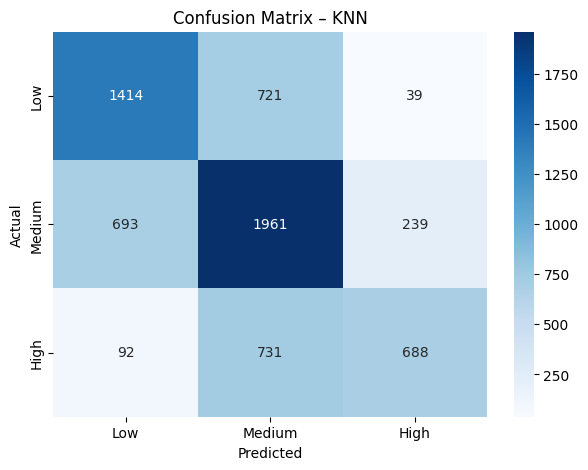

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# 1. Calcola la confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])


# 2. Crea la figura

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – KNN')
plt.show()


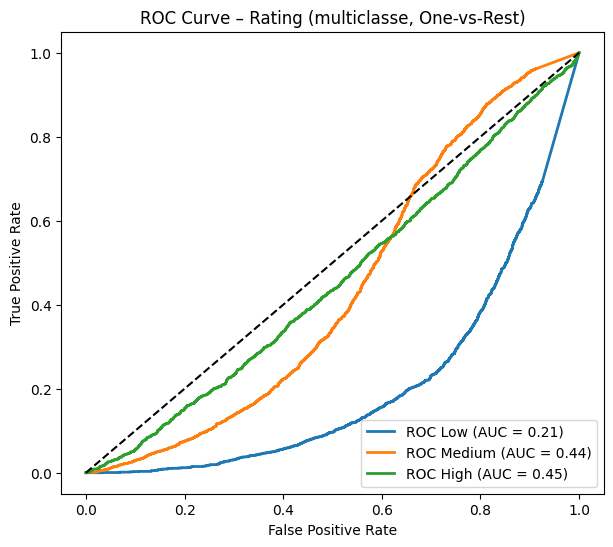

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# binarizza le classi
y_test_bin = label_binarize(y_test, classes=['Low','Medium','High'])
n_classes = y_test_bin.shape[1]

# predizioni probabilità
y_score = best_knn.predict_proba(X_test)

plt.figure(figsize=(7,6))
for i, class_name in enumerate(['Low','Medium','High']):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_score[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC {class_name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')  # baseline casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Rating (multiclasse, One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()


## target rating dopo che ho aggiunto le sintetiche

In [ ]:
# monto il drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importo il df
import pandas as pd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
dfOk = pd.read_csv('/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv')
df = dfOk.copy()

In [ ]:
def engineer_player_features(df):
    """Player count features"""
    df["RangePlayers"] = df["MaxPlayers"] - df["MinPlayers"]
    df["IsSoloPlayable"] = (df["MinPlayers"] == 1).astype(int)
    df["IsPartySize"] = (df["MaxPlayers"] >= 8).astype(int)
    return df

def engineer_playtime_features(df):
    """Playtime consistency"""
    df["PlaytimeRange"] = df["ComMaxPlaytime"] - df["ComMinPlaytime"]
    return df

def engineer_popularity_features(df):
    """Popularity-based features"""
    df["DemandRatio"] = df["NumWant"] / (df["NumOwned"] + 1)
    df["OwnershipRatio"] = df["NumOwned"] / (df["NumOwned"] + df["NumWant"] + 1)
    return df

def engineer_category_features(df):
    """Count number of categories"""
    cat_cols = [
        'Cat:Thematic','Cat:Strategy','Cat:War','Cat:Family',
        'Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens'
    ]
    df["NumCategories"] = df[cat_cols].sum(axis=1)
    return df

def engineer_rank_features(df):
    """Ranking features: BestRank, AvgRank, RankSpread"""

    rank_cols = [
        'Rank:strategygames','Rank:abstracts','Rank:familygames',
        'Rank:thematic','Rank:cgs','Rank:wargames',
        'Rank:partygames','Rank:childrensgames'
    ]

    # Step 1 — 21926 = "missing", convert to NaN
    df[rank_cols] = df[rank_cols].replace(21926, np.nan)

    # Step 2 — BestRank: se tutte NaN → usa un valore neutro (es. 25000 o NaN)
    df["BestRank"] = df[rank_cols].fillna(25000).min(axis=1)

    # Step 3 — AvgRank: media dei valori REALI, ignorando NaN
    df["AvgRank"] = df[rank_cols].mean(axis=1)

    # Step 4 — Spread: differenza tra valori validi
    df["RankSpread"] = df[rank_cols].max(axis=1) - df[rank_cols].min(axis=1)

    return df

def apply_all_feature_engineering(df):
    """Apply all FE steps in correct order"""
    df = engineer_player_features(df)
    df = engineer_playtime_features(df)
    df = engineer_popularity_features(df)
    df = engineer_category_features(df)
    df = engineer_rank_features(df)
    return df

In [ ]:
df = apply_all_feature_engineering(df)

In [ ]:

df.columns.to_list()

['BGGId',
 'Name',
 'Description',
 'YearPublished',
 'GameWeight',
 'MinPlayers',
 'MaxPlayers',
 'ComAgeRec',
 'LanguageEase',
 'BestPlayers',
 'GoodPlayers',
 'NumOwned',
 'NumWant',
 'NumWeightVotes',
 'ComMinPlaytime',
 'ComMaxPlaytime',
 'MfgAgeRec',
 'NumAlternates',
 'NumExpansions',
 'NumImplementations',
 'IsReimplementation',
 'Kickstarted',
 'Rank:strategygames',
 'Rank:abstracts',
 'Rank:familygames',
 'Rank:thematic',
 'Rank:cgs',
 'Rank:wargames',
 'Rank:partygames',
 'Rank:childrensgames',
 'Cat:Thematic',
 'Cat:Strategy',
 'Cat:War',
 'Cat:Family',
 'Cat:CGS',
 'Cat:Abstract',
 'Cat:Party',
 'Cat:Childrens',
 'Rating',
 'LanguageEase_log',
 'RangePlayers',
 'IsSoloPlayable',
 'IsPartySize',
 'PlaytimeRange',
 'DemandRatio',
 'OwnershipRatio',
 'NumCategories',
 'BestRank',
 'AvgRank',
 'RankSpread']

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Added MinMaxScaler to imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

df_knn = df.copy()

# Trasformazione target Rating in numerico
rating_map = {'Low': 1, 'Medium': 2, 'High': 3}
df_knn['Rating_num'] = df_knn['Rating'].map(rating_map)
y = df_knn['Rating_num'].values  # target numerico

# Selezione feature numeriche (esclude target)
numeric_cols = df_knn.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Rating_num' in numeric_cols:
    numeric_cols.remove('Rating_num')
X = df_knn[numeric_cols]

# Handle NaN values by imputing with the mean
X = X.fillna(X.mean())

# Selezione migliori feature con SelectKBest
k = 10  # numero di feature migliori
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Feature selezionate:", selected_features.tolist())
print("Punteggi di tutte le feature:")
for f, s in zip(X.columns, selector.scores_):
    print(f"{f}: {s:.2f}")



Feature selezionate: ['BGGId', 'GameWeight', 'ComAgeRec', 'BestPlayers', 'NumWant', 'ComMaxPlaytime', 'Rank:wargames', 'IsSoloPlayable', 'PlaytimeRange', 'OwnershipRatio']
Punteggi di tutte le feature:
BGGId: 2084.05
YearPublished: 67.13
GameWeight: 2789.98
MinPlayers: 415.56
MaxPlayers: 322.31
ComAgeRec: 898.55
LanguageEase: 30.20
BestPlayers: 662.14
NumOwned: 463.24
NumWant: 1780.91
NumWeightVotes: 285.40
ComMinPlaytime: 495.68
ComMaxPlaytime: 1253.94
MfgAgeRec: 352.74
NumAlternates: 22.50
NumExpansions: 268.26
NumImplementations: 100.07
IsReimplementation: 204.72
Kickstarted: 458.46
Rank:strategygames: 644.11
Rank:abstracts: 351.71
Rank:familygames: 579.85
Rank:thematic: 364.34
Rank:cgs: 111.22
Rank:wargames: 998.94
Rank:partygames: 201.39
Rank:childrensgames: 234.08
Cat:Thematic: 80.13
Cat:Strategy: 518.89
Cat:War: 402.67
Cat:Family: 99.62
Cat:CGS: 1.94
Cat:Abstract: 40.83
Cat:Party: 27.48
Cat:Childrens: 354.23
LanguageEase_log: 59.41
RangePlayers: 152.43
IsSoloPlayable: 673.50
IsP

In [ ]:
# 1. FEATURES e TARGET

features = ['GameWeight', 'ComAgeRec', 'BestPlayers', 'NumWant', 'ComMaxPlaytime', 'PlaytimeRange', 'OwnershipRatio']
target = ['Rating' ]

X = df_knn[features].copy()
y = df_knn[target].copy()

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# 3. TRAIN-TEST SPLIT (70% train, 30% test)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# 4. RANDOMIZED SEARCH


param_dist = {
    "n_neighbors": randint(1, 50),   # esplora k da 1 a 100
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(
    knn,
    param_distributions=param_dist,
    n_iter=40,          # 40 combinazioni casuali → molto più veloce
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

best_knn = random_search.best_estimator_


Best parameters: {'metric': 'cityblock', 'n_neighbors': 47, 'weights': 'distance'}
Best CV accuracy: 0.6025936150408148


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
# 5. VALUTAZIONE SUL TEST SET

best_knn = random_search.best_estimator_
y_pred = best_knn.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 0.6134083307996352

Classification Report:
               precision    recall  f1-score   support

        High       0.68      0.46      0.55      1511
         Low       0.64      0.67      0.65      2174
      Medium       0.57      0.66      0.61      2893

    accuracy                           0.61      6578
   macro avg       0.63      0.59      0.60      6578
weighted avg       0.62      0.61      0.61      6578


Confusion Matrix:
 [[ 690   78  743]
 [  57 1449  668]
 [ 273  724 1896]]


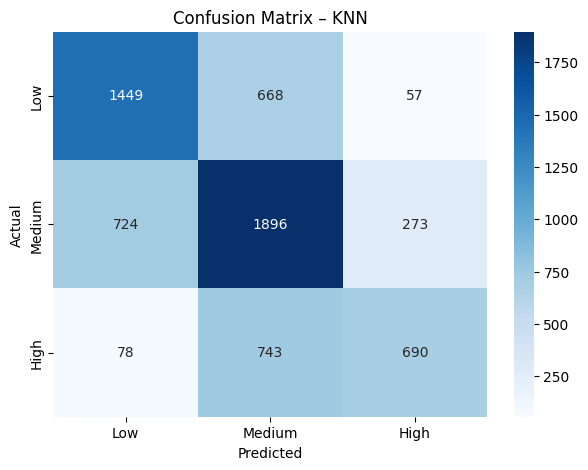

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# 1. Calcola la confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])


# 2. Crea la figura
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – KNN')
plt.show()


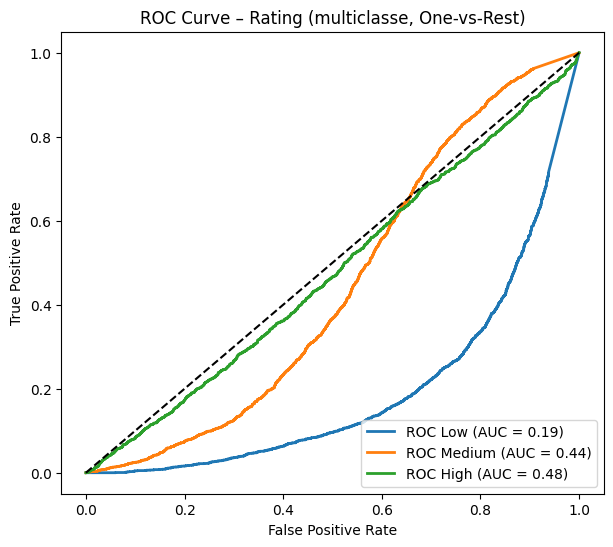

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# binarizza le classi
y_test_bin = label_binarize(y_test, classes=['Low','Medium','High'])
n_classes = y_test_bin.shape[1]

# predizioni probabilità
y_score = best_knn.predict_proba(X_test)

plt.figure(figsize=(7,6))
for i, class_name in enumerate(['Low','Medium','High']):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_score[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC {class_name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')  # baseline casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Rating (multiclasse, One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()


## selectKBest

In [ ]:
# Import
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Caricamento dati
df = pd.read_csv('/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv')
df_knn = df.copy()

# Trasformazione target Rating in numerico
rating_map = {'Low': 1, 'Medium': 2, 'High': 3}
df_knn['Rating_num'] = df_knn['Rating'].map(rating_map)
y = df_knn['Rating_num'].values  # target numerico

# Selezione feature numeriche (esclude target)
numeric_cols = df_knn.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Rating_num' in numeric_cols:
    numeric_cols.remove('Rating_num')
X = df_knn[numeric_cols]

# Selezione migliori feature con SelectKBest
k = 5  # numero di feature migliori
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Feature selezionate:", selected_features.tolist())
print("Punteggi di tutte le feature:")
for f, s in zip(X.columns, selector.scores_):
    print(f"{f}: {s:.2f}")

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, stratify=y)

#Standardizzazione
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Valutazione
y_pred = knn.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Feature selezionate: ['BGGId', 'GameWeight', 'ComAgeRec', 'NumWant', 'ComMaxPlaytime']
Punteggi di tutte le feature:
BGGId: 2084.05
YearPublished: 67.13
GameWeight: 2789.98
MinPlayers: 415.56
MaxPlayers: 322.31
ComAgeRec: 898.55
LanguageEase: 30.20
BestPlayers: 662.14
NumOwned: 463.24
NumWant: 1780.91
NumWeightVotes: 285.40
ComMinPlaytime: 495.68
ComMaxPlaytime: 1253.94
MfgAgeRec: 352.74
NumAlternates: 22.50
NumExpansions: 268.26
NumImplementations: 100.07
IsReimplementation: 204.72
Kickstarted: 458.46
Rank:strategygames: 547.49
Rank:abstracts: 38.90
Rank:familygames: 103.82
Rank:thematic: 85.70
Rank:cgs: 1.84
Rank:wargames: 475.25
Rank:partygames: 27.27
Rank:childrensgames: 348.13
Cat:Thematic: 80.13
Cat:Strategy: 518.89
Cat:War: 402.67
Cat:Family: 99.62
Cat:CGS: 1.94
Cat:Abstract: 40.83
Cat:Party: 27.48
Cat:Childrens: 354.23
LanguageEase_log: 59.41
Accuracy: 0.6082098061573546
              precision    recall  f1-score   support

           1       0.60      0.66      0.63      1449

## target rating dopo selectKBest

In [ ]:
# monto il drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importo il df
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv')

In [ ]:
df_knn = df.copy()
df_knn.columns.to_list()

['BGGId',
 'Name',
 'Description',
 'YearPublished',
 'GameWeight',
 'MinPlayers',
 'MaxPlayers',
 'ComAgeRec',
 'LanguageEase',
 'BestPlayers',
 'GoodPlayers',
 'NumOwned',
 'NumWant',
 'NumWeightVotes',
 'ComMinPlaytime',
 'ComMaxPlaytime',
 'MfgAgeRec',
 'NumAlternates',
 'NumExpansions',
 'NumImplementations',
 'IsReimplementation',
 'Kickstarted',
 'Rank:strategygames',
 'Rank:abstracts',
 'Rank:familygames',
 'Rank:thematic',
 'Rank:cgs',
 'Rank:wargames',
 'Rank:partygames',
 'Rank:childrensgames',
 'Cat:Thematic',
 'Cat:Strategy',
 'Cat:War',
 'Cat:Family',
 'Cat:CGS',
 'Cat:Abstract',
 'Cat:Party',
 'Cat:Childrens',
 'Rating',
 'LanguageEase_log']

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# 1. FEATURES e TARGET

features = [ 'GameWeight', 'ComAgeRec', 'NumWant', 'ComMaxPlaytime']
target = ['Rating' ]       # target che è categorica con Low Medium Hight

X = df_knn[features].copy()
y = df_knn[target].copy()

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# 3. TRAIN-TEST SPLIT (70% train, 30% test)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 4. RANDOMIZED SEARCH

param_dist = {
    "n_neighbors": randint(1, 50),   # esplora k da 1 a 100
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(
    knn,
    param_distributions=param_dist,
    n_iter=40,          # 40 combinazioni casuali → molto più veloce
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

best_knn = random_search.best_estimator_


Best parameters: {'metric': 'cityblock', 'n_neighbors': 40, 'weights': 'uniform'}
Best CV accuracy: 0.5693623425597787


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
# 5. VALUTAZIONE SUL TEST SET
best_knn = random_search.best_estimator_
y_pred = best_knn.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 0.5830039525691699

Classification Report:
               precision    recall  f1-score   support

        High       0.64      0.43      0.51      1511
         Low       0.60      0.64      0.62      2174
      Medium       0.55      0.62      0.58      2893

    accuracy                           0.58      6578
   macro avg       0.60      0.56      0.57      6578
weighted avg       0.59      0.58      0.58      6578


Confusion Matrix:
 [[ 647  110  754]
 [  68 1392  714]
 [ 292  805 1796]]


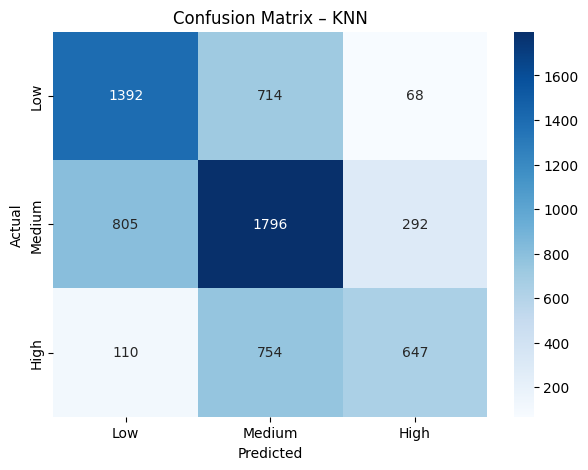

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# 1. Calcola la confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])


# 2. Crea la figura

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – KNN')
plt.show()


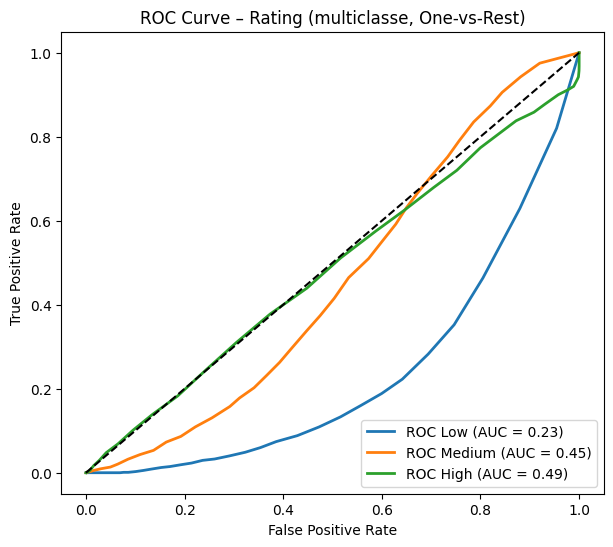

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# binarizza le classi
y_test_bin = label_binarize(y_test, classes=['Low','Medium','High'])
n_classes = y_test_bin.shape[1]

# predizioni probabilità
y_score = best_knn.predict_proba(X_test)

plt.figure(figsize=(7,6))
for i, class_name in enumerate(['Low','Medium','High']):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_score[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC {class_name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')  # baseline casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Rating (multiclasse, One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()
